In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import polars as pl
import seaborn as sns
from scipy import stats

DATA_PRODUCTS='data/products.csv'
DATA_STORES='data/stores.csv'
DATA_TRANSACTIONS='data/transactions.csv'

In [2]:
products = pd.read_csv(DATA_PRODUCTS,
                       converters={'Price': lambda x: float(x.replace('$','').replace(',',''))}
                       )

transactions = pd.read_csv(DATA_TRANSACTIONS,
                           converters={'Price': lambda x: float(x.replace('$','').replace(',',''))},
                           parse_dates=['PurchaseDate']
                           )

stores = pd.read_csv(DATA_STORES)

data = pd.merge(transactions, products, on=['ProductID','Price'], how='left').merge(stores, on='StoreID', how='left')
data['PurchaseMonth'] = data['PurchaseDate'].dt.to_period('M')
data['Location'] = data['StoreCity'] + ', ' + data['StoreState']

#data.to_parquet('data/ALL_DATA.parquet')
data #print(data.head())

,CustomerID,StoreID,PurchaseDate,ProductID,Price,ProductName,ProductType,ProductCategory,StoreCity,StoreState,PurchaseMonth,Location
0,J47338598,101,2023-06-06,1045,25.99,Pink Beanie,Beanie,Headwear,Abilene,TX,2023-06,"Abilene, TX"
1,J47338598,101,2023-06-06,1068,1000.99,Bookshelf,Shelving and Storage,Furniture,Abilene,TX,2023-06,"Abilene, TX"
2,J47641989,102,2023-06-12,1027,33.99,Green Long Sleeve,Long Sleeve,Clothing,Akron,OH,2023-06,"Akron, OH"
3,J48280578,101,2023-06-03,1016,48.99,Neon Pants,Pants,Clothing,Abilene,TX,2023-06,"Abilene, TX"
4,J48327939,101,2023-06-06,1065,2000.99,Dining table,Table,Furniture,Abilene,TX,2023-06,"Abilene, TX"
...,...,...,...,...,...,...,...,...,...,...,...,...
127199,JZ3496,145,2023-06-08,1063,38.99,Purple Sneakers,Sneakers,Footwear,Carmel,IN,2023-06,"Carmel, IN"
127200,JZ3496,145,2023-06-08,1043,25.99,Green Beanie,Beanie,Headwear,Carmel,IN,2023-06,"Carmel, IN"
127201,JZ3496,145,2023-06-08,1025,33.99,Blue Long Sleeve,Long Sleeve,Clothing,Carmel,IN,2023-06,"Carmel, IN"
127202,JZ3496,145,2023-06-08,1080,3000.99,Writing desk,Desk,Furniture,Carmel,IN,2023-06,"Carmel, IN"


In [3]:
data.describe(include='all')

,CustomerID,StoreID,PurchaseDate,ProductID,Price,ProductName,ProductType,ProductCategory,StoreCity,StoreState,PurchaseMonth,Location
count,127204,127204.000000,127204,127204.000000,127204.000000,127204,127204,127204,127204,127204,127204,127204
unique,27521,NaN,NaN,NaN,NaN,108,15,4,96,33,1,102
top,J313327794,NaN,NaN,NaN,NaN,Sofa,Seating,Furniture,Akron,OH,2023-06,"Akron, OH"
freq,660,NaN,NaN,NaN,NaN,1268,19813,51678,22637,26420,127204,22637
mean,NaN,135.484953,2023-06-07 11:30:21.112543744,1054.353582,403.089156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,101.000000,2023-06-01 00:00:00,1001.000000,19.990000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,109.000000,2023-06-04 00:00:00,1027.000000,33.990000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,133.000000,2023-06-08 00:00:00,1055.000000,38.990000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,159.000000,2023-06-11 00:00:00,1081.000000,500.990000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,202.000000,2023-06-14 00:00:00,1108.000000,5000.990000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# SALES OVER TIME PER STORE

sales_over_time = data.groupby(['PurchaseDate', 'Location']).agg({'Price': 'sum', }).reset_index().rename(columns={'Price': 'Total Sales ($)', 'PurchaseDate': 'Purchase Date'})
fig = px.line(sales_over_time, x='Purchase Date', y='Total Sales ($)', color='Location', title='Sales Over Time')

#pio.write_image(fig, 'sales_over_time.svg')  # Save as SVG
fig

In [5]:
# TOP SELLING PRODUCTS
# TOP SELLING PRODUCT CATEGORIES

top_selling_products = data.groupby(['ProductID','ProductName','ProductType','ProductCategory','StoreState']).agg({'Price': 'sum'}).reset_index()
top_selling_products = top_selling_products.sort_values('Price', ascending=False)
top_selling_products

top_selling_product_cats_by_state = top_selling_products.groupby(['StoreState', 'ProductCategory']).agg({'Price': 'sum'}).reset_index()
top_selling_product_cats_by_state

pivoted_df = top_selling_product_cats_by_state.pivot(index='StoreState', columns='ProductCategory', values='Price')

# Sort the columns by price in descending order
pivoted_df = pivoted_df.apply(lambda x: x.sort_values(ascending=False), axis=1)

pivoted_df = pivoted_df.reset_index()
pivoted_df.columns.name = None
cats_ranked_by_state = pd.DataFrame()

for idx,g in pivoted_df.groupby('StoreState'):
    
    g = g.reset_index(drop=True).T.reset_index().rename({'index': 'Product Category', 0: 'Total Sales ($)'}, axis=1).drop([0], axis=0)
    g = g.sort_values('Total Sales ($)', ascending=False).reset_index(drop=True).T
    
    
    gg = pd.concat([pd.Series({'State': idx}), g.loc['Total Sales ($)'], g.loc['Product Category']]).to_frame()
    gg.index = ['State', '#1 Sales','#2 Sales','#3 Sales','#4Sales','#1 Cat','#2 Cat','#3 Cat','#4 Cat',]
    gg = gg.T
    gg
    
    cats_ranked_by_state = pd.concat([cats_ranked_by_state, gg])

cats_ranked_by_state.head()

#cats_ranked_by_state.sort_values('#1 Sales', ascending=False)
# The nevada Store is the only one that doesn't sell all four categories of products. For this period they are missing any records on Footwear sales, althoug they are also the lowest grossing store overall, so I'm not sure what the status is over there.
cats_ranked_by_state

,State,#1 Sales,#2 Sales,#3 Sales,#4Sales,#1 Cat,#2 Cat,#3 Cat,#4 Cat
0,AK,753297.94,21481.02,10422.15,6061.37,Furniture,Clothing,Footwear,Headwear
0,AL,318532.64,8173.72,4562.74,2678.84,Furniture,Clothing,Footwear,Headwear
0,AZ,454170.25,13714.17,6505.22,4036.23,Furniture,Clothing,Footwear,Headwear
0,CA,7773228.89,219373.68,112023.29,67752.48,Furniture,Clothing,Footwear,Headwear
0,CO,3505303.59,95153.63,50548.12,30196.83,Furniture,Clothing,Footwear,Headwear
0,CT,577360.34,15862.64,7167.04,4669.97,Furniture,Clothing,Footwear,Headwear
0,FL,1937352.27,53297.09,27423.51,18112.08,Furniture,Clothing,Footwear,Headwear
0,GA,818140.51,22777.57,12601.55,7052.91,Furniture,Clothing,Footwear,Headwear
0,HI,731274.18,21970.9,11335.89,6797.05,Furniture,Clothing,Footwear,Headwear
0,IA,895551.39,25704.85,12605.54,7830.56,Furniture,Clothing,Footwear,Headwear


In [6]:
# PLOTTING SALES CATEGORIES BY STATE ON A MAP

fig = px.choropleth(cats_ranked_by_state, 
                    locations='State', 
                    locationmode='USA-states', 
                    color='#1 Cat',
                    scope='usa',
                    title='#1 Category Sales by State')

fig.update_layout(geo=dict(bgcolor='rgba(0,0,0,0)'))

fig.show()

In [7]:
top_sales_by_state = top_selling_product_cats_by_state.groupby('StoreState').agg({'Price': 'sum'}).reset_index().sort_values('Price', ascending=False)

fig = px.choropleth(top_sales_by_state, 
                    locations='StoreState', 
                    locationmode='USA-states', 
                    color='Price',
                    scope='usa',
                    title='Total Sales by State')
fig

In [8]:
# REPEAT CUSTOMERS
# PURCHASE SIZE DISTRIBUTION


data

df_customer_agg = data.groupby(['CustomerID', 'PurchaseDate']).agg({'Price': 'sum'}).reset_index()
df_avg_spend_per_day = df_customer_agg.groupby('CustomerID').agg({'Price': 'mean'}).reset_index()
df_avg_spend_per_day.rename(columns={'Price': 'Average Spend per Day'}, inplace=True)
df_avg_spend_per_day

fig = px.histogram(df_avg_spend_per_day, x='Average Spend per Day', nbins=10, marginal='box', title='Average Spend per Day Distribution')
fig.show()


/var/folders/9k/dw63pngx37g_xc1f36r8dxsr0000gn/T/ipykernel_80211/21404450.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



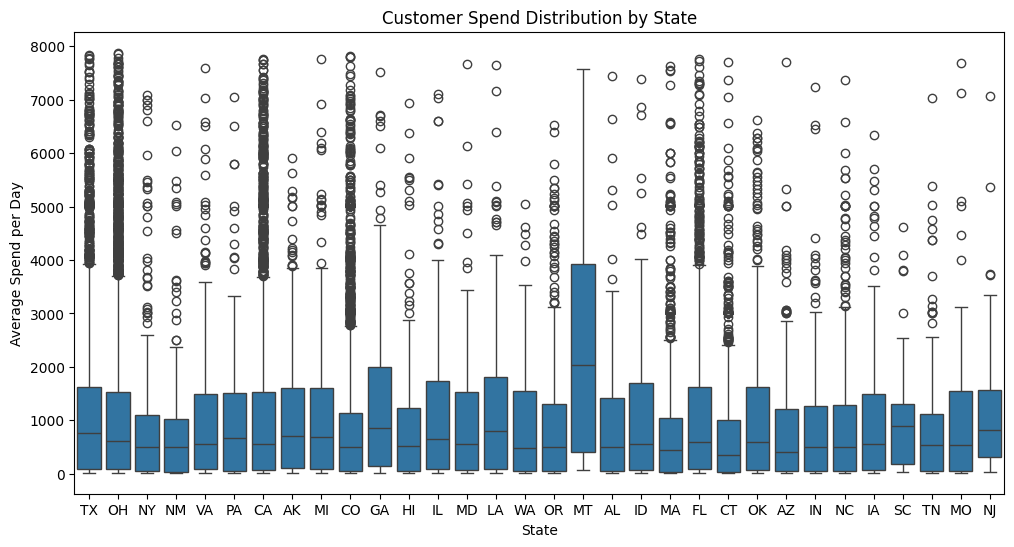

In [30]:
# CUSTOMER SPEND DISTRIBUTION BY STATE

# Filter out outliers using z-score
df_filtered = df_avg_spend_per_day[(np.abs(stats.zscore(df_avg_spend_per_day['Average Spend per Day'])) < 3)]
df_filtered['StoreState'] = data.loc[df_filtered.index, 'StoreState']

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='StoreState', y='Average Spend per Day', data=df_filtered)
plt.title('Customer Spend Distribution by State')
plt.xlabel('State')
plt.ylabel('Average Spend per Day')
plt.show()



In [12]:

# SALES BY STATE / CITY

# DAYS OF THE WEEK ANALYSIS

# PRICE DISTRIBUTION OF ALL THE PRODUCTS

In [13]:
#df_customer_monthly_agg = data.drop(['PurchaseDate'], axis=1).groupby(['ProductID','']).
#data
#.groupby(['ProductID','']).

#df_customer_agg = data.groupby('CustomerID').agg({'Price':'sum', 'PurchaseDate':'count'}).reset_index()
df_customer_agg = data.groupby(['CustomerID','PurchaseDate']).agg({'Price':'sum'}).reset_index()
df_customer_agg #['AvgSpend']

,CustomerID,PurchaseDate,Price
0,J100100,2023-06-09,39.98
1,J1003052126,2023-06-14,3183.94
2,J1003193828,2023-06-08,500.99
3,J1003644578,2023-06-14,33.99
4,J1003953191,2023-06-05,73.98
...,...,...,...
37210,JFASTCC134,2023-06-14,2561.96
37211,JFASTCC144,2023-06-02,1000.99
37212,JFASTCC144,2023-06-08,300.99
37213,JM02725,2023-06-09,260.97
